In [2]:
import graphmethods as gr
from preprocessor import *
from recommender_system import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.preprocessing import LabelEncoder
from stellargraph import StellarGraph
from stellargraph.mapper import Attri2VecNodeGenerator, GraphSAGENodeGenerator
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

[nltk_data] Downloading package stopwords to /Users/heidi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2022-05-19 07:14:36.185157: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
nodes = pd.read_csv("data/nodes.csv")
nodes = nodes.set_index("Id")
alinks = pd.read_csv("data/alinks.csv")
bilinks = pd.read_csv("data/bilinks.csv")
clinks = create_clinks(bilinks,nodes)

FileNotFoundError: [Errno 2] No such file or directory: 'data/nodes.csv'

## Homogeneous graph
with all products and Amazon's similarity connections (`alinks`)

In [ ]:
G = nx.from_pandas_edgelist(alinks, source='source', target='target')

In [ ]:
missing_nodes = list(set(nodes.index)-set(G.nodes()))
len(missing_nodes)
G.add_nodes_from(missing_nodes)

In [ ]:
gr.net_prop_dict(G)


{'no_of_nodes': 542664,
 'no_of_edges': 236429,
 'transitivity': 0.007141223411014257,
 'average_clustering': 0.003951630468176218,
 'edge_density': 1.6057188950565498e-06,
 'average_degree': 0.8713642327480725,
 'total_triangles': 3372,
 'number_connected_components': 307498}

## Bipartite graph

In [ ]:
bilinks.head()

,Id,CId,Rating
0,1,C110643,5.0
1,2,C133242,5.0
2,3,C3314,5.0
3,4,C217326,4.0
4,5,C7580,5.0


In [ ]:
# collect bi-edge tuples into list
biedges = []
for i in range(bilinks.shape[0]):
    biedges.append((bilinks.loc[i,"CId"],bilinks.loc[i,"Id"]))
# collect ids of customer nodes and product nodes into lists
customers = list(bilinks.CId.unique())
products = list(bilinks.Id.unique())
len(customers), len(products), len(biedges)

(229313, 410480, 410480)

In [ ]:
from networkx.algorithms import bipartite

biG = nx.Graph()
#nodes
biG.add_nodes_from(customers, bipartite="customers")
biG.add_nodes_from(products, bipartite="products")
#edges
biG.add_edges_from(biedges)
bipartite.is_bipartite(biG)

True

In [ ]:
gr.net_prop_dict(biG)

{'no_of_nodes': 639793,
 'no_of_edges': 410480,
 'transitivity': 0,
 'average_clustering': 0.0,
 'edge_density': 2.005597168591275e-06,
 'average_degree': 1.2831650236873489,
 'total_triangles': 0,
 'number_connected_components': 229313}

## Another homogeneous graph
with all products and edges connecting products of same customer

In [ ]:
CG = nx.from_pandas_edgelist(clinks, source='source', target='target')

In [ ]:
missing_nodes = list(set(nodes.index)-set(CG.nodes()))
print(len(missing_nodes))
CG.add_nodes_from(missing_nodes)

422303


In [ ]:
# gr.net_prop_dict(CG)

## StellarGraphs

Stellargraph accepts only numerical features.

In [ ]:
node_data = nodes[["Group","Salesrank","AvgRating"]]
enc = LabelEncoder()
node_data["GroupCode"] = enc.fit_transform(node_data["Group"].values)
node_data = node_data[["GroupCode","Salesrank","AvgRating"]]
node_data.sample(3)

/var/folders/hk/kbn1q_sj4jz4lh0m7x05vff80000gn/T/ipykernel_9858/646165351.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node_data["GroupCode"] = enc.fit_transform(node_data["Group"].values)


,GroupCode,Salesrank,AvgRating
Id,,,
494890,0,2722852,0.0
528958,0,239317,3.5
73711,0,745504,0.0


In [ ]:
prod_groups = {k: v for v,k in enumerate(enc.classes_)}
prod_groups

{'Book': 0, 'DVD': 1, 'Music': 2, 'Video': 3}

**Homogeneous graph** where links are between products the same customer has rated them with 5 stars.

In [ ]:
clinks_graph = StellarGraph({"product": node_data}, {"similar":clinks})
print(clinks_graph.info())

StellarGraph: Undirected multigraph
 Nodes: 542664, Edges: 70093382

 Node types:
  product: [542664]
    Features: float32 vector, length 3
    Edge types: product-similar->product

 Edge types:
    product-similar->product: [70093382]
        Weights: all 1 (default)
        Features: none


**Homogeneous graph** where links represent the similar products and the similarity is taken from source data.

In [ ]:
alinks_graph = StellarGraph({"product": node_data}, {"similar":alinks[["source","target"]]})
print(alinks_graph.info())

StellarGraph: Undirected multigraph
 Nodes: 542664, Edges: 275230

 Node types:
  product: [542664]
    Features: float32 vector, length 3
    Edge types: product-similar->product

 Edge types:
    product-similar->product: [275230]
        Weights: all 1 (default)
        Features: none


**Heterogeneous graph** where we have different entity types: Book, DVD, Music, Video

In [ ]:
het_clinks_graph = StellarGraph(
    {"Book": node_data[node_data.GroupCode==prod_groups["Book"]],
     "DVD": node_data[node_data.GroupCode==prod_groups["DVD"]],
     "Music": node_data[node_data.GroupCode==prod_groups["Music"]],
     "Video": node_data[node_data.GroupCode==prod_groups["Video"]]}, 
    {"Customer_similarity": clinks})
print(het_clinks_graph.info())

StellarGraph: Undirected multigraph
 Nodes: 542664, Edges: 70093382

 Node types:
  Book: [393561]
    Features: float32 vector, length 3
    Edge types: Book-Customer_similarity->Book, Book-Customer_similarity->DVD, Book-Customer_similarity->Music, Book-Customer_similarity->Video
  Music: [103144]
    Features: float32 vector, length 3
    Edge types: Music-Customer_similarity->Book, Music-Customer_similarity->DVD, Music-Customer_similarity->Music, Music-Customer_similarity->Video
  Video: [26131]
    Features: float32 vector, length 3
    Edge types: Video-Customer_similarity->Book, Video-Customer_similarity->DVD, Video-Customer_similarity->Music, Video-Customer_similarity->Video
  DVD: [19828]
    Features: float32 vector, length 3
    Edge types: DVD-Customer_similarity->Book, DVD-Customer_similarity->DVD, DVD-Customer_similarity->Music, DVD-Customer_similarity->Video

 Edge types:
    Book-Customer_similarity->Book: [36697972]
        Weights: all 1 (default)
        Features: non

In [ ]:
het_alinks_graph = StellarGraph(
    {"Book": node_data[node_data.GroupCode==prod_groups["Book"]],
     "DVD": node_data[node_data.GroupCode==prod_groups["DVD"]],
     "Music": node_data[node_data.GroupCode==prod_groups["Music"]],
     "Video": node_data[node_data.GroupCode==prod_groups["Video"]]}, 
    {"Amazon_similarity": alinks[["source","target"]]})
print(het_alinks_graph.info())

StellarGraph: Undirected multigraph
 Nodes: 542664, Edges: 275230

 Node types:
  Book: [393561]
    Features: float32 vector, length 3
    Edge types: Book-Amazon_similarity->Book, Book-Amazon_similarity->DVD, Book-Amazon_similarity->Music, Book-Amazon_similarity->Video
  Music: [103144]
    Features: float32 vector, length 3
    Edge types: Music-Amazon_similarity->Book, Music-Amazon_similarity->DVD, Music-Amazon_similarity->Music, Music-Amazon_similarity->Video
  Video: [26131]
    Features: float32 vector, length 3
    Edge types: Video-Amazon_similarity->Book, Video-Amazon_similarity->DVD, Video-Amazon_similarity->Music, Video-Amazon_similarity->Video
  DVD: [19828]
    Features: float32 vector, length 3
    Edge types: DVD-Amazon_similarity->Book, DVD-Amazon_similarity->DVD, DVD-Amazon_similarity->Music, DVD-Amazon_similarity->Video

 Edge types:
    Book-Amazon_similarity->Book: [202903]
        Weights: all 1 (default)
        Features: none
    Music-Amazon_similarity->Music: 

**Random subgraph**

In [ ]:
random_sub_graph, random_nodes = generate_random_subgraph("product",node_data,"similar",alinks,size=100000)
print(random_sub_graph.info())

StellarGraph: Undirected multigraph
 Nodes: 100000, Edges: 9354

 Node types:
  product: [100000]
    Features: float32 vector, length 3
    Edge types: product-similar->product

 Edge types:
    product-similar->product: [9354]
        Weights: all 1 (default)
        Features: none


## Attri2vec

Implementing Attri2vec on **random subgraph**:

1. Train the Attri2vec model:

In [ ]:
x_inp_a2v, x_out_a2v, history_a2v, model_a2v = attri2vec_model(G=random_sub_graph, batch_size=100, epochs=1)

Generate samples ...
Attri2vec model ...
link_classification: using 'ip' method to combine node embeddings into edge embeddings
Keras model ...
Train the model ...
2815/2815 [==============================] - 96s 34ms/step - loss: 0.7130 - binary_accuracy: 0.4900


In [ ]:
model_a2v.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 32)           96          ['input_1[0][0]']                
                                                                                                  
 output_embedding (Embedding)   (None, 1, 32)        3200000     ['input_2[0][0]']                
                                                                                              

2. Generate embeddings:

In [ ]:
node_embeddings_a2v = generate_embeddings(features=random_nodes, 
                                      generator=Attri2VecNodeGenerator(G=random_sub_graph, batch_size=10), 
                                      x_inp_src=x_inp_a2v[0], x_out_src = x_out_a2v[0])

10000/10000 [==============================] - 24s 2ms/step


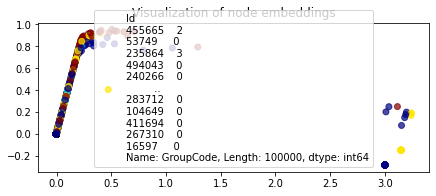

In [ ]:
plot_embeddings(node_embeddings_a2v, random_nodes.GroupCode, PCA(n_components=2))

Implementing Attri2vec on **whole graph with Amazon's similarities**:

In [ ]:
x_inp_a2v_2, x_out_a2v_2, history_a2v_2, model_a2v_2 = attri2vec_model(G=alinks_graph, batch_size=100, epochs=1)

Generate samples ...
Attri2vec model ...
link_classification: using 'ip' method to combine node embeddings into edge embeddings
Keras model ...
Train the model ...
59292/59292 [==============================] - 7353s 124ms/step - loss: 0.7172 - binary_accuracy: 0.5016


In [ ]:
node_embeddings_a2v_2 = generate_embeddings(features=node_data, 
                                      generator=Attri2VecNodeGenerator(G=alinks_graph, batch_size=100), 
                                      x_inp_src=x_inp_a2v_2[0], x_out_src = x_out_a2v_2[0])

5427/5427 [==============================] - 6s 1ms/step


/opt/anaconda3/envs/NS/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


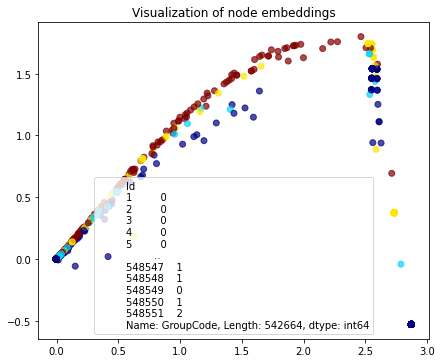

In [ ]:
plot_embeddings(node_embeddings_a2v_2, node_data.GroupCode, PCA(n_components=2))

## GraphSAGE

Implementing on the **random subgraph** for testing purposes:

1. Training model:

In [ ]:
x_inp_gs, x_out_gs, history_gs, model_gs = graphsage_model(G=random_sub_graph,batch_size=100,epochs=1)

Generate samples ...
GraphSAGE model ...
link_classification: using 'ip' method to combine node embeddings into edge embeddings
Keras model ...
Train ...
1126/1126 [==============================] - 102s 90ms/step - loss: 0.7347 - binary_accuracy: 0.5549


In [ ]:
model_gs.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 10, 3)]      0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 50, 3)]      0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 10, 3)]      0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 50, 3)]      0           []                               
                                                                                            

2. Calculating embeddings with trained model:

In [ ]:
node_embeddings = generate_embeddings(features=random_nodes, 
                    generator=GraphSAGENodeGenerator(G=random_sub_graph, batch_size=100, num_samples=[10, 5]), 
                    x_inp_src=x_inp_gs[0::2], x_out_src=x_out_gs[0])

1000/1000 [==============================] - 16s 16ms/step


In [ ]:
node_embeddings.shape

(100000, 50)

3. Plotting embeddings with the help of feature reduction:

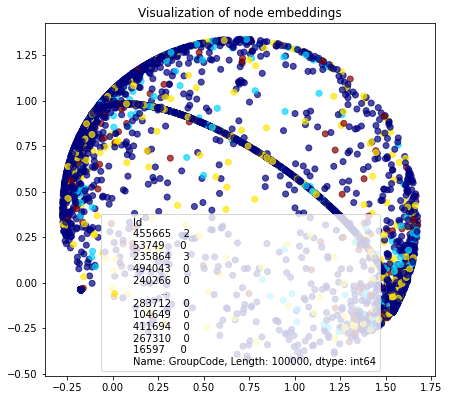

In [ ]:
plot_embeddings(node_embeddings,random_nodes.GroupCode,PCA(n_components=2))

Implementing GraphSAGE on whole graph with (Amazon's) similarity links:

1. Training the model:

In [ ]:
x_inp_gs_2, x_out_gs_2, history_gs_2, model_gs_2 = graphsage_model(G=alinks_graph,number_of_walks=3, length=3,
                                        batch_size=100, epochs = 1, num_samples=[10,5],
                                        layer_sizes=[64,32])

Generate samples ...
GraphSAGE model ...
link_classification: using 'ip' method to combine node embeddings into edge embeddings
Keras model ...
Train ...
35575/35575 [==============================] - 3667s 103ms/step - loss: 0.7288 - binary_accuracy: 0.5589


2. Calculating node embeddings:

In [ ]:
node_embeddings = generate_embeddings(features=node_data, 
                    generator=GraphSAGENodeGenerator(G=alinks_graph, batch_size=100, num_samples=[10, 5]), 
                    x_inp_src=x_inp_gs_2[0::2], x_out_src=x_out_gs_2[0])

5427/5427 [==============================] - 130s 24ms/step


3. Plotting nodes using PCA for feature reduction:

/opt/anaconda3/envs/NS/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


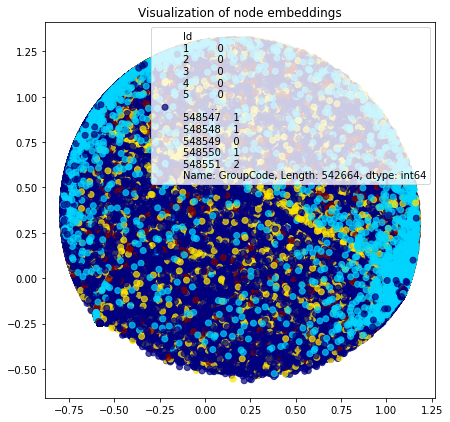

In [ ]:
plot_embeddings(node_embeddings,node_data.GroupCode,PCA(n_components=2))

4. Plotting nodes using TSNE for feature reduction (takes much more longer than PCA):

/opt/anaconda3/envs/NS/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/NS/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


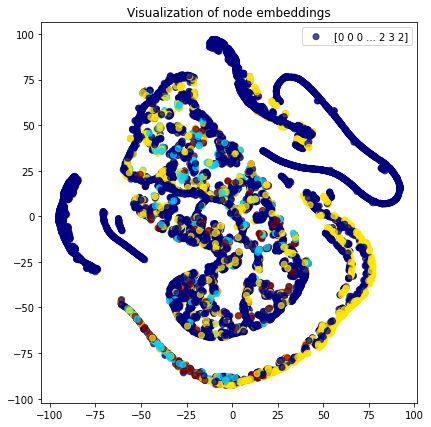

In [ ]:
plot_embeddings(node_embeddings[:10000,:],node_data.GroupCode.values[:10000],TSNE(n_components=2))

## Find recommendations
using embeddings and Nearest Neighbour algorithm

In [1]:
# embeddings to dataframe, index from the node attribute table which was used to create graph
X = pd.DataFrame(data=node_embeddings,index=node_data.index)
X_a2v_2 = pd.DataFrame(data=node_embeddings_a2v_2,index=node_data.index)

NameError: name 'pd' is not defined

Generate 5 random products:

In [197]:
randoms = np.random.choice(random_nodes.index,size=5,replace=False)

Find 5 recommendations for each product:

In [198]:
recommendations = recommender(randoms,5,X,nodes)

For product Book 'Everything Happens for a Reason' we recommend: 
1. Book 'The Corporate Mule: Don't Give Up Your Soul for the Company Goal : A Novel';
2. Book 'Vocabulary and Language Teaching (Applied Linguistics and Language Study)';
3. Book 'Women, Work, and Pensions: International Issues and Prospects';
4. Book 'A Companion to Beethoven's Pianoforte Sonatas: Complete Analyses';
5. Book 'Monologues from Moliere';
For product Book 'Animals in the Fall (Preparing for Winter)' we recommend: 
1. Book 'The Official Overstreet Comic Book Price Guide, 32nd Edition (Overstreet Comic Book Price Guide)';
2. Music 'Beautiful My Child';
3. Book 'Orchid Blues (Holly Barker Novels (Hardcover))';
4. Book 'Little Miss Somersault (Mr. Men and Little Miss)';
5. Book 'War of Words: Getting to the Heart of Your Communication Struggles (Resources for Changing Lives)';
For product Music 'Play Bach [2002]' we recommend: 
1. DVD 'Planet Out.Com: Short Movie Awards';
2. DVD 'Adventures of Pinocchio';
3. DV

In [199]:
randoms, recommendations

(array([477590, 124250, 116655, 113170,  64740]),
 array([[472175, 480717, 213152,  25617, 344276],
        [122906, 369993, 191409, 481514, 354258],
        [115394, 542330, 340867, 265143, 254467],
        [111938, 431841, 274401, 404620,  60177],
        [ 64041, 540977, 372806, 512309,  38048]]))

In [241]:
sim_table = calc_similarities(G,randoms)

In [242]:
sim_table.sample(5)

,477590_adamics,477590_jaccards,477590_prefatts,124250_adamics,124250_jaccards,124250_prefatts,116655_adamics,116655_jaccards,116655_prefatts,113170_adamics,113170_jaccards,113170_prefatts,64740_adamics,64740_jaccards,64740_prefatts
51023,0,0.0,0,0.0,0.0,0,0,0.0,0,0,0.0,0,0.0,0.0,0
462414,0,0.0,0,0.0,0.0,4,0,0.0,0,0,0.0,0,0.0,0.0,4
405732,0,0.0,0,0.0,0.0,0,0,0.0,0,0,0.0,0,0.0,0.0,0
507562,0,0.0,0,0.0,0.0,3,0,0.0,0,0,0.0,0,0.0,0.0,3
544923,0,0.0,0,0.0,0.0,2,0,0.0,0,0,0.0,0,0.0,0.0,2


We can see that our graph is so sparse that similarity metrics are mostly zeros.

Percentages of zero values in columns:

In [243]:
100 * np.sum(sim_table==0)/542664

477590_adamics     100.000000
477590_jaccards    100.000000
477590_prefatts    100.000000
124250_adamics      99.999447
124250_jaccards     99.999447
124250_prefatts     45.369879
116655_adamics     100.000000
116655_jaccards    100.000000
116655_prefatts    100.000000
113170_adamics     100.000000
113170_jaccards    100.000000
113170_prefatts    100.000000
64740_adamics       99.999631
64740_jaccards      99.999631
64740_prefatts      45.369879
dtype: float64

In [273]:
recoms_min, dists_min = recoms_with_distances(randoms,5,X,nodes)

For product Book 'Everything Happens for a Reason' we recommend: 
1. Book 'The Corporate Mule: Don't Give Up Your Soul for the Company Goal : A Novel': 2.107342389479072e-08
2. Book 'Vocabulary and Language Teaching (Applied Linguistics and Language Study)': 5.1619135632563484e-08
3. Book 'Women, Work, and Pensions: International Issues and Prospects': 6.989264278445262e-08
4. Book 'A Companion to Beethoven's Pianoforte Sonatas: Complete Analyses': 7.146346092667955e-08
5. Book 'Monologues from Moliere': 7.450580596923828e-08
For product Book 'Animals in the Fall (Preparing for Winter)' we recommend: 
1. Book 'The Official Overstreet Comic Book Price Guide, 32nd Edition (Overstreet Comic Book Price Guide)': 0.0
2. Music 'Beautiful My Child': 0.002347250934690237
3. Book 'Orchid Blues (Holly Barker Novels (Hardcover))': 0.004107864107936621
4. Book 'Little Miss Somersault (Mr. Men and Little Miss)': 0.0042238193564116955
5. Book 'War of Words: Getting to the Heart of Your Communication 

In [274]:
recoms_jac, dists_jac = recoms_with_distances(randoms,5,X,nodes,metric='jaccard')

/opt/anaconda3/envs/NS/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1975: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


For product Book 'Everything Happens for a Reason' we recommend: 
1. Book 'Langenscheidt New College German Dictionary: German-English - English German Thumb-indexed': 0.0
2. Book 'Repositioning Asia : From Bubble to Sustainable Economy': 0.0
3. Music 'Sacred Steel: Traditional Sacred African-American Steel Guitar Music In Florida': 0.0
4. Music 'Cowboy Up: The Official PRCA Rodeo Album': 0.0
5. Music 'Angola Prison Worksongs': 0.0
For product Book 'Animals in the Fall (Preparing for Winter)' we recommend: 
1. Book 'Langenscheidt New College German Dictionary: German-English - English German Thumb-indexed': 0.0
2. Book 'Repositioning Asia : From Bubble to Sustainable Economy': 0.0
3. Music 'Sacred Steel: Traditional Sacred African-American Steel Guitar Music In Florida': 0.0
4. Music 'Cowboy Up: The Official PRCA Rodeo Album': 0.0
5. Music 'Angola Prison Worksongs': 0.0
For product Music 'Play Bach [2002]' we recommend: 
1. Book 'Langenscheidt New College German Dictionary: German-Engl

In [276]:
recoms_euc, dists_euc = recoms_with_distances(randoms,5,X,nodes,metric='euclidean')

For product Book 'Everything Happens for a Reason' we recommend: 
1. Book 'The Corporate Mule: Don't Give Up Your Soul for the Company Goal : A Novel': 2.107342389479072e-08
2. Book 'Vocabulary and Language Teaching (Applied Linguistics and Language Study)': 5.1619135632563484e-08
3. Book 'Women, Work, and Pensions: International Issues and Prospects': 6.989264278445262e-08
4. Book 'A Companion to Beethoven's Pianoforte Sonatas: Complete Analyses': 7.146346092667955e-08
5. Book 'Monologues from Moliere': 7.450580596923828e-08
For product Book 'Animals in the Fall (Preparing for Winter)' we recommend: 
1. Book 'The Official Overstreet Comic Book Price Guide, 32nd Edition (Overstreet Comic Book Price Guide)': 0.0
2. Music 'Beautiful My Child': 0.002347250934690237
3. Book 'Orchid Blues (Holly Barker Novels (Hardcover))': 0.004107864107936621
4. Book 'Little Miss Somersault (Mr. Men and Little Miss)': 0.0042238193564116955
5. Book 'War of Words: Getting to the Heart of Your Communication 

In [277]:
recoms_man, dists_man = recoms_with_distances(randoms,5,X,nodes,metric='manhattan')

For product Book 'Everything Happens for a Reason' we recommend: 
1. Book 'The Corporate Mule: Don't Give Up Your Soul for the Company Goal : A Novel': 0.0
2. Book 'Vocabulary and Language Teaching (Applied Linguistics and Language Study)': 2.163376393582439e-07
3. Book 'Ordinary Differential Equations': 2.522508566471515e-07
4. Book 'Small Engines - Workbook': 2.5776967049750965e-07
5. Book 'Huguenot Heritage: The History and Contribution of the Huguenots in Britain': 2.592410055513028e-07
For product Book 'Animals in the Fall (Preparing for Winter)' we recommend: 
1. Book 'The Official Overstreet Comic Book Price Guide, 32nd Edition (Overstreet Comic Book Price Guide)': 0.0
2. Music 'Beautiful My Child': 0.007270322646945715
3. Book 'Little Miss Somersault (Mr. Men and Little Miss)': 0.010818075970746577
4. Book 'Orchid Blues (Holly Barker Novels (Hardcover))': 0.012504938640631735
5. Book 'War of Words: Getting to the Heart of Your Communication Struggles (Resources for Changing Liv

In [278]:
recoms_can, dists_can = recoms_with_distances(randoms,5,X,nodes,metric='canberra')

For product Book 'Everything Happens for a Reason' we recommend: 
1. Book 'The Corporate Mule: Don't Give Up Your Soul for the Company Goal : A Novel': 0.0
2. Book 'Ordinary Differential Equations': 0.00014654824362281068
3. Book 'The Oxford Color Thesaurus': 0.0002555185498807632
4. Book 'A Way of Light': 0.0005239148662258918
5. Book 'Funky Snowman (Holiday Cards)': 0.0006155249391892235
For product Book 'Animals in the Fall (Preparing for Winter)' we recommend: 
1. Book 'The Official Overstreet Comic Book Price Guide, 32nd Edition (Overstreet Comic Book Price Guide)': 0.0
2. Book 'The Passionate Learner : How Teachers and Parents Can Help Children Reclaim the Joy of Discovery': 0.20112208791370303
3. Book 'Little Miss Somersault (Mr. Men and Little Miss)': 0.21652332473833188
4. Book 'Progressive Popular Classics of the Great Composers (Progressive Young Beginners)': 0.22930818280414095
5. Book 'Spanish Decorative Ironwork: With over 300 Illustrations (Dover Pictorial Archive Series

In [279]:
recoms_can

array([[472175, 413373, 277007, 275425, 386014],
       [122906, 431449, 481514, 454617, 380410],
       [115394, 542330, 340867, 265143, 414724],
       [111938, 409448, 274401, 535957, 179641],
       [ 64041, 372806, 540977, 469471, 354994]])

In [281]:
recoms_ex, dists_ex = recoms_with_distances([413373],10,X,nodes,metric='canberra')

For product Book 'Ordinary Differential Equations' we recommend: 
1. Book 'New Perspectives on Racial Identity Development: A Theoretical and Practical Anthology': 0.0
2. Book 'Early Medieval Architecture (Oxford History of Art)': 0.02912242060610261
3. Book 'Forgotten Traditions of Ancient Chinese Medicine: A Chinese View from the Eighteenth Century': 0.034714205724526076
4. Book 'Piano Music 1888-1905': 0.03635138561488203
5. Book 'Jewish Wisdom in the Hellenistic Age (Old Testament Library)': 0.03755226696541708
6. Book 'For Freedom's Sake: The Life of Fannie Lou Hamer (Women in American History)': 0.04768622170128029
7. Book 'A Picture for Harold's Room': 0.04968661401656147
8. Book 'Us and Them': 0.05134575942149007
9. Book 'Speech After Stroke: A Manual for the Speech Pathologist and the Family Member': 0.051867991664105856
10. Book 'Self Study Bible Course': 0.05242889106849586


In [283]:
recoms_with_distances([413373],10,X,nodes,metric='manhattan')

For product Book 'Ordinary Differential Equations' we recommend: 
1. Book 'New Perspectives on Racial Identity Development: A Theoretical and Practical Anthology': 0.0
2. Book 'Piano Music 1888-1905': 0.0037333709187805653
3. Book 'Forgotten Traditions of Ancient Chinese Medicine: A Chinese View from the Eighteenth Century': 0.004229085519909859
4. Book 'Early Medieval Architecture (Oxford History of Art)': 0.005138689652085304
5. Book 'For Freedom's Sake: The Life of Fannie Lou Hamer (Women in American History)': 0.005720074288547039
6. Book 'Japanese Street Slang': 0.006933593424037099
7. Music 'New Edition': 0.007252936251461506
8. Book 'Us and Them': 0.007587513420730829
9. Book 'Jewish Wisdom in the Hellenistic Age (Old Testament Library)': 0.007963450392708182
10. Book 'Speech After Stroke: A Manual for the Speech Pathologist and the Family Member': 0.008565748576074839


(array([[408685, 142784, 211175, 256967,  92266, 444315, 233164, 285268,
          26903, 245235]]),
 array([[0.        , 0.00373337, 0.00422909, 0.00513869, 0.00572007,
         0.00693359, 0.00725294, 0.00758751, 0.00796345, 0.00856575]]))

In [275]:
X.loc[randoms[:2]]

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
Id,,,,,,,,,,,,,,,,,,,,,
477590,0.007892,0.304213,-0.016629,-0.001241,0.007815,0.531985,-0.008904,0.636965,-0.434645,0.010656,...,0.000010,-0.000011,-0.000013,0.000010,0.000012,-0.000013,0.000008,0.000012,-0.000013,-0.000013
124250,0.001310,0.064338,0.001007,-0.001435,0.000688,0.078520,0.000495,0.090709,-0.067894,0.018652,...,0.209563,-0.200297,-0.248200,0.180711,0.253898,-0.272761,0.202728,0.258962,-0.284269,-0.250720


In [260]:
sim_table.head()

,477590_adamics,477590_jaccards,477590_prefatts,124250_adamics,124250_jaccards,124250_prefatts,116655_adamics,116655_jaccards,116655_prefatts,113170_adamics,113170_jaccards,113170_prefatts,64740_adamics,64740_jaccards,64740_prefatts
500600,0,0.0,0,0.0,0.0,1,0,0.0,0,0,0.0,0,0.0,0.0,1
1,0,0.0,0,0.0,0.0,2,0,0.0,0,0,0.0,0,0.0,0.0,2
454888,0,0.0,0,0.0,0.0,1,0,0.0,0,0,0.0,0,0.0,0.0,1
2,0,0.0,0,0.0,0.0,1,0,0.0,0,0,0.0,0,0.0,0.0,1
355935,0,0.0,0,0.0,0.0,1,0,0.0,0,0,0.0,0,0.0,0.0,1


In [312]:
def print_sim_products(nodes_df, similarity_df, max_similars=10):
    for col in similarity_df.columns:
        prod = int(col.split('_')[0])
        group = node_info.loc[prod,"Group"]
        title = node_info.loc[prod,"Title"]
        df = similarity_df[similarity_df[col]>0]
        df = df.sort_values(col,ascending=False)
        similars = df.index
        values = list(df[col].values)
        if len(similars)==0: continue
        print(f"Product {group} '{title}':")
        print(f"Metric {col.split('_')[1]}: ")
        for i,similar in enumerate(similars):
            if i >= max_similars: break
            group = str(node_info.loc[similar,"Group"])
            title = str(node_info.loc[similar,"Title"])
            print(f"{i+1}. {group} '{title}': {values[i]}")

In [269]:
print_sim_products(nodes,sim_table)

Product Book 'The Official Overstreet Comic Book Price Guide, 32nd Edition (Overstreet Comic Book Price Guide)':
Metric adamics: 
1. Book 'The Official Overstreet Comic Book Price Guide, 32nd Edition (Overstreet Comic Book Price Guide)': 0.9102392266268373
2. Book 'The Official Overstreet Comic Book Price Guide, 33rd edition (Official Overstreet Comic Book Price Guide)': 0.9102392266268373
3. Book 'The Official Overstreet Comic Book Price Guide, 31st Edition (Overstreet Comic Book Price Guide, 31st)': 0.9102392266268373
Product Book 'The Official Overstreet Comic Book Price Guide, 32nd Edition (Overstreet Comic Book Price Guide)':
Metric jaccards: 
1. Book 'The Official Overstreet Comic Book Price Guide, 32nd Edition (Overstreet Comic Book Price Guide)': 1.0
2. Book 'The Official Overstreet Comic Book Price Guide, 33rd edition (Official Overstreet Comic Book Price Guide)': 1.0
3. Book 'The Official Overstreet Comic Book Price Guide, 31st Edition (Overstreet Comic Book Price Guide, 31st

In [258]:
node_info = nodes.set_index("Id")
for col in sim_table.columns:
    prod = int(col.split('_')[0])
    group = node_info.loc[prod,"Group"]
    title = node_info.loc[prod,"Title"]
    print(f"Product {group} '{title}': metric {col.split('_')[1]}: ")
    df = sim_table[sim_table[col]>0]
    df = df.sort_values(col,ascending=False)
    similars = df.index
    values = list(df[col].values)
    for i,similar in enumerate(similars):
        group = str(node_info.loc[similar,"Group"])
        title = str(node_info.loc[similar,"Title"])
        print(f"{i+1}. {group} '{title}': {values[i]}")
        if i >= 10: break

Product Book 'The Corporate Mule: Don't Give Up Your Soul for the Company Goal : A Novel': metric adamics: 
Product Book 'The Corporate Mule: Don't Give Up Your Soul for the Company Goal : A Novel': metric jaccards: 
Product Book 'The Corporate Mule: Don't Give Up Your Soul for the Company Goal : A Novel': metric prefatts: 
Product Book 'The Official Overstreet Comic Book Price Guide, 32nd Edition (Overstreet Comic Book Price Guide)': metric adamics: 
1. Book 'The Official Overstreet Comic Book Price Guide, 32nd Edition (Overstreet Comic Book Price Guide)': 0.9102392266268373
2. Book 'The Official Overstreet Comic Book Price Guide, 33rd edition (Official Overstreet Comic Book Price Guide)': 0.9102392266268373
3. Book 'The Official Overstreet Comic Book Price Guide, 31st Edition (Overstreet Comic Book Price Guide, 31st)': 0.9102392266268373
Product Book 'The Official Overstreet Comic Book Price Guide, 32nd Edition (Overstreet Comic Book Price Guide)': metric jaccards: 
1. Book 'The Offi

In [238]:
recommendations_a2v_2 = recommender(randoms,5,X_a2v_2,nodes)

For product Book 'Everything Happens for a Reason' we recommend: 
1. Book 'LOVE SICK';
2. Book 'Taltos';
3. Book 'Tim McGraw and the Dancehall Doctors: This Is Ours';
4. Book 'Go Home, Fatso';
5. Book 'Edmund Dulac - His Book Illustrations: A Bibliography';
For product Book 'Animals in the Fall (Preparing for Winter)' we recommend: 
1. Book 'LOVE SICK';
2. Book 'Taltos';
3. Book 'Tim McGraw and the Dancehall Doctors: This Is Ours';
4. Book 'Go Home, Fatso';
5. Book 'Edmund Dulac - His Book Illustrations: A Bibliography';
For product Music 'Play Bach [2002]' we recommend: 
1. Book 'LOVE SICK';
2. Book 'Taltos';
3. Book 'Tim McGraw and the Dancehall Doctors: This Is Ours';
4. Book 'Go Home, Fatso';
5. Book 'Edmund Dulac - His Book Illustrations: A Bibliography';
For product Book 'Jingle Bear (reissue) (Serendipity)' we recommend: 
1. Book 'LOVE SICK';
2. Book 'Taltos';
3. Book 'Tim McGraw and the Dancehall Doctors: This Is Ours';
4. Book 'Go Home, Fatso';
5. Book 'Edmund Dulac - His Book

In [239]:
recoms_a2v_2, dists_a2v_2 = recoms_with_distances(randoms,5,X_a2v_2,nodes)

For product Book 'Everything Happens for a Reason' we recommend: 
1. Book 'LOVE SICK': 0.0
2. Book 'Taltos': 0.0
3. Book 'Tim McGraw and the Dancehall Doctors: This Is Ours': 0.0
4. Book 'Go Home, Fatso': 0.0
5. Book 'Edmund Dulac - His Book Illustrations: A Bibliography': 0.0
For product Book 'Animals in the Fall (Preparing for Winter)' we recommend: 
1. Book 'LOVE SICK': 0.0
2. Book 'Taltos': 0.0
3. Book 'Tim McGraw and the Dancehall Doctors: This Is Ours': 0.0
4. Book 'Go Home, Fatso': 0.0
5. Book 'Edmund Dulac - His Book Illustrations: A Bibliography': 0.0
For product Music 'Play Bach [2002]' we recommend: 
1. Book 'LOVE SICK': 0.0
2. Book 'Taltos': 0.0
3. Book 'Tim McGraw and the Dancehall Doctors: This Is Ours': 0.0
4. Book 'Go Home, Fatso': 0.0
5. Book 'Edmund Dulac - His Book Illustrations: A Bibliography': 0.0
For product Book 'Jingle Bear (reissue) (Serendipity)' we recommend: 
1. Book 'LOVE SICK': 0.0
2. Book 'Taltos': 0.0
3. Book 'Tim McGraw and the Dancehall Doctors: This 

In [284]:
r,d = recoms_with_distances(randoms,5, X_a2v_2, nodes, metric='manhattan')

For product Book 'Everything Happens for a Reason' we recommend: 
1. Book 'Sims Book 2: The Portero Method (Sims)': 0.0
2. Book 'The Rainbow Serpent': 0.0
3. Book 'Wheeler's Dental Anatomy, Physiology and Occlusion': 0.0
4. Book 'Your Bridge to a Better Future': 0.0
5. Book 'The Boy Who Found Hashem': 0.0
For product Book 'Animals in the Fall (Preparing for Winter)' we recommend: 
1. Book 'Sims Book 2: The Portero Method (Sims)': 0.0
2. Book 'The Rainbow Serpent': 0.0
3. Book 'Wheeler's Dental Anatomy, Physiology and Occlusion': 0.0
4. Book 'Your Bridge to a Better Future': 0.0
5. Book 'The Boy Who Found Hashem': 0.0
For product Music 'Play Bach [2002]' we recommend: 
1. Book 'Sims Book 2: The Portero Method (Sims)': 0.0
2. Book 'The Rainbow Serpent': 0.0
3. Book 'Wheeler's Dental Anatomy, Physiology and Occlusion': 0.0
4. Book 'Your Bridge to a Better Future': 0.0
5. Book 'The Boy Who Found Hashem': 0.0
For product Book 'Jingle Bear (reissue) (Serendipity)' we recommend: 
1. Book 'Sim

In [286]:
selection = [548548, 548549, 548550, 548551]

In [290]:
r,d = recoms_with_distances(selection,5, X_a2v_2, node_info, metric='manhattan')

For product DVD 'The House Of Morecock' we recommend: 
1. Book 'Robertson's Practical English-Thai Dictionary': 0.0
2. Book 'Hide and Sneak (Hardy Boys (Hardcover))': 0.709054172039032
3. Book 'The Kingdom of Infinite Number: A Field Guide': 1.2382665276527405
4. Book 'A King's Cutter (Mariner's Library Fiction Classics)': 1.3349066078662872
5. DVD 'My Favorite Broadway - The Leading Ladies': 1.4109865427017212
For product Book 'Catholic Bioethics and the Gift of Human Life' we recommend: 
1. Book 'Ghost of a Chance': 0.0
2. Book 'Out of the Ruins (Wright, Sally S. Ben Reese Mystery Series, 4.)': 0.0
3. Music 'Soul On Fire': 0.0
4. DVD 'My Favorite Broadway - The Leading Ladies': 0.0
5. Video 'Exposure: Environmental Links to Breast Cancer': 0.0
For product DVD '1, 2, 3 Soleils: Taha, Khaled, Faudel' we recommend: 
1. Book 'Business Decision Making in China': 0.0
2. Music 'The Best of Candy Dulfer': 0.0
3. Book 'Inside Barcelona : Discovering the Classic Interiors of Barcelona (Inside.

In [291]:
r,d = recoms_with_distances(selection,5, X_a2v_2, node_info, metric='minkowski')

For product DVD 'The House Of Morecock' we recommend: 
1. Book 'Robertson's Practical English-Thai Dictionary': 5.960464477539063e-08
2. Book 'Hide and Sneak (Hardy Boys (Hardcover))': 0.1490022838115692
3. Book 'The Kingdom of Infinite Number: A Field Guide': 0.3123815655708313
4. Music 'II': 0.32492175698280334
5. Music 'The Best of Candy Dulfer': 0.3369734585285187
For product Book 'Catholic Bioethics and the Gift of Human Life' we recommend: 
1. Book 'Out of the Ruins (Wright, Sally S. Ben Reese Mystery Series, 4.)': 8.429369557916289e-08
2. Music 'Soul On Fire': 8.429369557916289e-08
3. DVD 'My Favorite Broadway - The Leading Ladies': 8.429369557916289e-08
4. Video 'Exposure: Environmental Links to Breast Cancer': 8.429369557916289e-08
5. Book 'Citizen Coors : A Grand Family Saga of Business, Politics, and Beer': 8.429369557916289e-08
For product DVD '1, 2, 3 Soleils: Taha, Khaled, Faudel' we recommend: 
1. Book 'Business Decision Making in China': 8.429369557916289e-08
2. Music '

In [294]:
degree_centrality = nx.degree_centrality(G)

In [299]:
degree_tbl = pd.DataFrame(data=degree_centrality.values(),index=degree_centrality.keys(),columns=["Degree_Centrality"])
degree_tbl = degree_tbl.sort_values("Degree_Centrality",ascending=False)
tbl = degree_tbl.join(node_info[["Group","Title"]])

In [300]:
tbl.head(10)

,Degree_Centrality,Group,Title
548091,0.000160,DVD,Laura
458358,0.000140,Book,Diagnostic and Statistical Manual of Mental Di...
239107,0.000127,Book,The Prince
222074,0.000116,Book,Publication Manual of the American Psychologic...
45146,0.000111,Book,Taber's Cyclopedic Medical Dictionary -Thumb-I...
239327,0.000109,Book,Confessions (Oxford World's Classics)
55387,0.000105,Book,Getting to Yes: Negotiating Agreement Without ...
27832,0.000103,Book,The Winter's Tale (Folger Shakespeare Library)
277567,0.000101,Book,The Secret Garden
436020,0.000101,Book,The TEMPEST


In [303]:
tbl = tbl.reset_index()
tbl["Degree"] = tbl.apply(lambda row: G.degree[int(row["index"])],axis=1)
tbl = tbl.set_index("index")
tbl.head(10)

,Degree_Centrality,Group,Title,Degree
index,,,,
548091,0.000160,DVD,Laura,87
458358,0.000140,Book,Diagnostic and Statistical Manual of Mental Di...,76
239107,0.000127,Book,The Prince,69
222074,0.000116,Book,Publication Manual of the American Psychologic...,63
45146,0.000111,Book,Taber's Cyclopedic Medical Dictionary -Thumb-I...,60
239327,0.000109,Book,Confessions (Oxford World's Classics),59
55387,0.000105,Book,Getting to Yes: Negotiating Agreement Without ...,57
27832,0.000103,Book,The Winter's Tale (Folger Shakespeare Library),56
277567,0.000101,Book,The Secret Garden,55


In [308]:
sample_products = [list(tbl.index)[0]]
metrics = ['minkowski','manhattan','canberra']
embs = {"GraphSAGE": X,"Attri2vec": X_a2v_2} # GraphSAGE, Attri2vec
for product in sample_products:
    for emb in embs: 
        for metric in metrics:
            print(product, f"{node_info.loc[product,'Group']} '{node_info.loc[product,'Title']}':")
            print(f"{emb} embeddings: distance metric {metric}")
            recoms_with_distances([product],
                                  no_recommendations=5, 
                                  embeddings_df=embs[emb], 
                                  nodes_df=node_info, 
                                  metric=metric)
            print("")
    

548091 DVD 'Laura':
GraphSAGE embeddings: distance metric minkowski
For product DVD 'Laura' we recommend: 
1. DVD 'Michiganfest 2002': 0.0
2. Book 'The Pickwick Papers : BBC (BBC Radio Presents)': 0.000214374071219936
3. Book 'Chinese Brain Twisters : Fast, Fun Puzzles That Help Children Develop Quick Minds': 0.0008455562056042254
4. Book 'Cardiovascular Nutrition: Strategies and Tools for Disease Management and Prevention': 0.001189003000035882
5. Book 'Men in the Off Hours (Vintage Contemporaries)': 0.0014744069194421172

548091 DVD 'Laura':
GraphSAGE embeddings: distance metric manhattan
For product DVD 'Laura' we recommend: 
1. DVD 'Michiganfest 2002': 0.0
2. Book 'The Pickwick Papers : BBC (BBC Radio Presents)': 0.0006997332675382495
3. Book 'Chinese Brain Twisters : Fast, Fun Puzzles That Help Children Develop Quick Minds': 0.0033854282228276134
4. DVD 'Doctor Who - The Armageddon Factor (The Key to Time Series, Part 6)': 0.004233678453601897
5. Book 'Cardiovascular Nutrition: St

In [314]:
node_ids = list(G.nodes())
similarity = pd.DataFrame(index=node_ids)
for product in [548091]:
    # adamics = [list(nx.adamic_adar_index(G,[(product,idx)]))[0][2] for idx in node_ids]
    jaccards = [list(nx.jaccard_coefficient(G,[(product,idx)]))[0][2] for idx in node_ids]
    pref_att = [list(nx.preferential_attachment(G,[(product,idx)]))[0][2] for idx in node_ids]
    # similarity[f'{product}_adamics'] = adamics 
    similarity[f'{product}_jaccards'] = jaccards
    similarity[f'{product}_prefatts'] = pref_att
print_sim_products(nodes_df=node_info, similarity_df=similarity, max_similars=20)

Product DVD 'Laura':
Metric jaccards: 
1. DVD 'Laura': 1.0
2. Video 'Beloved Infidel': 0.011494252873563218
3. DVD 'The Strange Love of Martha Ivers / Kirk Douglas on Film - A Biography': 0.011494252873563218
4. DVD 'The Strange Love of Martha Ivers': 0.011494252873563218
5. DVD 'The Strange Love Of Martha Ivers': 0.011494252873563218
6. Book 'The Ghost and Mrs. Muir': 0.011494252873563218
7. Video 'The Fireball': 0.011494252873563218
8. Video 'Ladies of the Chorus': 0.011494252873563218
9. Video 'Last Holiday': 0.011494252873563218
10. DVD 'Wanted for Murder': 0.011494252873563218
11. DVD 'Cloak and Dagger': 0.011494252873563218
12. DVD 'Hangmen Also Die!': 0.011494252873563218
13. Video 'Cloak and Dagger': 0.011494252873563218
14. DVD 'Mademoiselle': 0.011494252873563218
15. Video 'Mississippi Mermaid': 0.011494252873563218
16. DVD 'Mississippi Mermaid': 0.011494252873563218
17. DVD 'Carnival Story': 0.011494252873563218
18. Video '5 Fingers': 0.011363636363636364
19. DVD 'Devil Doll